Run rnn0 on real data

In [13]:
# Colab:
! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
import sys 
sys.path.append('./ReinforcementRats2021')

fatal: destination path 'ReinforcementRats2021' already exists and is not an empty directory.


In [14]:
import nmastandard
from rnn0 import *
from gen_fake_data import *
from load_data import *
import pickle

In [15]:
device=nmastandard.set_device()  # select device

In [16]:
#assumes time is the 0 axis
def smoothData(data, sigma, size, method):
    import numpy as np
    from scipy.signal import fftconvolve
    from scipy.ndimage.filters import gaussian_filter
    
    if method =='gaussian':
        kernel_base = np.ones(shape=(size))
        kernel_1d = gaussian_filter(kernel_base, sigma=sigma, mode='reflect')
        kernel_1d = kernel_1d / np.sum(kernel_1d)


        kernel_3d = np.zeros(shape=(size, 1, 1))
        kernel_3d[:, 0, 0] = kernel_1d

        convolved= fftconvolve(data, kernel_3d, mode='same')
    elif method =='mean':
        kernel_base = np.ones(shape=(size))
        kernel_3d = np.zeros(shape=(size, 1, 1))
        kernel_3d[:, 0, 0] = kernel_base
        
        convolved= fftconvolve(data, kernel_3d, mode='same')/size
        
    return (convolved)
#@title Data retrieval and smooth function
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)




#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [17]:
# get spking and response data: specify subject and brain_area
dat = alldat[18]
brain_area="APN"
NeuronInd=dat['brain_area']==brain_area
spk=dat['spks']   # neuron, trial, time
spk=spk[NeuronInd,:,:]
resp=dat['response']; # response of each trial
spk=np.transpose(spk, (2, 1, 0))
spk.shape # time, trial, neuron

(250, 247, 185)

In [18]:
# prepare for training: get training data and validation data
spk=smoothData(spk, 10, 20, 'gaussian')   # smooth data

# load .pkl data
# file = open("./ReinforcementRats2021/superSmooth.pkl",'rb')
# spk = pickle.load(file)
# k=np.sum(spk,axis=0)>0
# spk=spk(:,k)
# NT=spk.shape[0]
ntrials=spk.shape[1]
# NN=spk.shape[2];
ncomp=2;    # number of latent variables



trainingData = torch.from_numpy(spk[:, :ntrials*4//5, :]).to(device).float()
train_resp=resp[:ntrials*4//5]
           
# trainingData=trainingData/trainingData.max()


testData = torch.from_numpy(spk[:, ntrials*4//5:, :]).to(device).float()

# testData[testData>0]=1



In [19]:
# we initialize the neural network
net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0.5 ,bidi = False).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = trainingData.mean((0,1))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


iteration 0, train_loss 0.4917 , val_loss 0.4831
iteration 50, train_loss 0.3065 , val_loss 0.2953
iteration 100, train_loss 0.2950 , val_loss 0.2846
iteration 150, train_loss 0.2915 , val_loss 0.2817


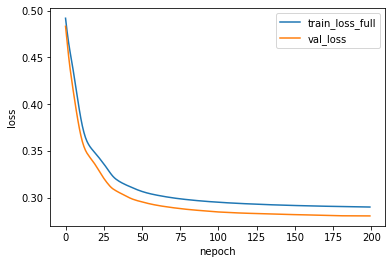

In [20]:
# train the rnn!
_,_,latv = rnn0.train(net,trainingData,trainingData,200,0.005,device,30, None, testData,testData)
# might not expect the model to generalize well, as the adjacency matrices might 
# differ between different neuron subpopulations

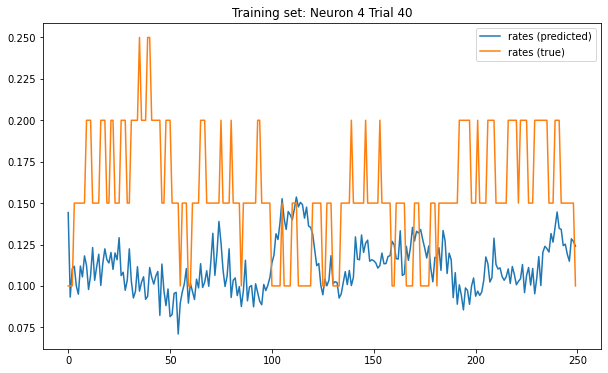

In [21]:
# visualize the performance of the rnn model
netinput=testData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 10
ntrial = 40

# # Plot for Test Data
# plt.figure(figsize=(10, 6))
# plt.plot(rpred[:,ntrial, nn], label='rates (predicted)')
# plt.plot(testData[:, ntrial, nn].detach().numpy(), label='rates (data)')
# plt.legend()
# plt.title(f'Validation set: Neuron {nn} Trial {ntrial}')
# plt.show()

# Plot for Training Data
netinput=trainingData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
nn = 4
ntrial = 40
plt.figure(figsize=(10, 6))

plt.plot(rpred[:,ntrial, nn], label='rates (predicted)')
plt.plot( trainingData[:, ntrial, nn].detach().cpu().numpy(), label='rates (true)')

plt.legend()
plt.title(f'Training set: Neuron {nn} Trial {ntrial}')
plt.show()

-1.0
0.0
1.0


Text(0.5, 1.0, 'mean of latents dynamics grouped by response types')

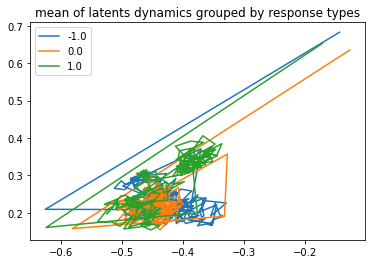

In [22]:
## Check latent variable dynamics
input=torch.tensor(spk,device=device)
input=input.permute(2,1,0)
# _,lat=net.rnn(input,ncomp)
latvd=latv.detach().cpu().numpy()
latvd.shape
for i, resp_type in enumerate(np.unique(train_resp)):
  print(resp_type)
  trial_ind=train_resp==resp_type
  plt.plot(latvd[:,trial_ind,0].mean(axis=1),latvd[:,trial_ind,1].mean(axis=1),label= resp_type)
plt.legend()
plt.title('mean of latents dynamics grouped by response types')

Text(0.5, 1.0, 'PCA Variance Explained Ratio')

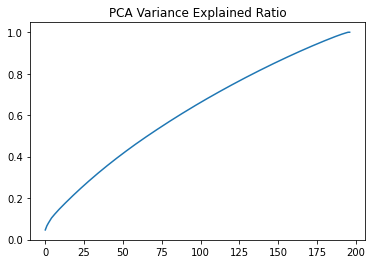

In [36]:
##generating PCA for reconstruction error 
n_componenents = 50
#print(np.shape(trainingData))
from sklearn.decomposition import PCA

trainingData_pca = trainingData.cpu().numpy()
a,b,c = np.shape(trainingData_pca)
pca = PCA().fit(trainingData_pca.reshape(-1, a * c))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title(f'PCA Variance Explained Ratio')

In [35]:
##this block of code is for reconstruction error from PCA 
###training mse and validation MSE, save to list that associates back setup with error
testData_pca = testData.cpu().numpy()

##needed neurons x trial-times (collapsing across times)
d,e,f = np.shape(trainingData_pca)#

##testPCA = testData.transform(testData_pca.reshape(-1, testData_pca.shape[-1]))
#should be neurons x trial-times
test_pca = PCA(n_componenents).fit(testData_pca.reshape(-1, d * f))

testReconstructed = PCA.inverse_transform(test_pca)
print(type(testReconstructed))

loss = np.sum((test_pca - testReconstructed) ** 2, axis=1).mean()

<class 'sklearn.decomposition._pca.PCA'>


TypeError: ignored